## SIIM Data Covid-19 SVM classifier
#### Configuration

In [3]:
# default config
model_name = "ResNet50"
learning_rate = 0.0001
min_learning_rate = 1e-8
batch_size = 25
epochs = 1
verbose = 1
img_process_function = "equalize_adapthist"
isKaggleData = False
classification_type = "binary"
classifier = "svm"

train_num = 10
val_num = 2
show_cv_scores = False
feature_number = 128

use_fine_tuning = False
use_chex_weights = True

libraries = ["pandas","numpy","sklearn","tensorflow","keras","skimage","matplotlib","seaborn"]
show_versions = True
svm_hyp_search = "grid"

show_model_summary = False
save_weights = False

#### Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from skimage import exposure

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, NASNetMobile, NASNetLarge, DenseNet121, ResNet50, Xception, InceptionResNetV2

import importlib
from skimage import exposure

import warnings
warnings.filterwarnings("ignore")

import os

In [5]:
def display_versions(libraries = None):
    
    from importlib import import_module
    
    for library in libraries:
        print(f"{library} version: {import_module(library).__version__}")

if show_versions:
    display_versions(libraries)

pandas version: 1.2.4
numpy version: 1.20.1
sklearn version: 0.24.1
tensorflow version: 2.3.0
keras version: 2.4.3
skimage version: 0.18.1
matplotlib version: 3.3.4
seaborn version: 0.11.1


#### Transfer Models

In [6]:
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, NASNetMobile, NASNetLarge, DenseNet121, ResNet50, Xception, InceptionResNetV2


def get_models():
    
    models_ = dict(
                    VGG16 = dict(
                        input_shape = (224,224,3),
                        module_name = "vgg16",
                        last_conv_layer = "block5_conv3",
                    ),
                    VGG19 = dict(
                        input_shape = (224,224,3),
                        module_name = "vgg19",
                        last_conv_layer = "block5_conv4",
                    ),
                    # this is used for ChexNet
                    DenseNet121=dict(
                        input_shape=(224, 224, 3),
                        module_name="densenet",
                        last_conv_layer="conv5_block16_concat",
                    ),
                    ResNet50=dict(
                        input_shape=(224, 224, 3),
                        module_name="resnet50",
                        last_conv_layer="conv5_block3_out",
                    ),
                    InceptionV3=dict(
                        input_shape=(299, 299, 3),
                        module_name="inception_v3",
                        last_conv_layer="mixed10",
                    ),
                    InceptionResNetV2=dict(
                        input_shape=(299, 299, 3),
                        module_name="inception_resnet_v2",
                        last_conv_layer="conv_7b_bn",
                    ),
                    NASNetMobile=dict(
                        input_shape=(224, 224, 3),
                        module_name="nasnet",
                        last_conv_layer="normal_concat_12",
                    ),
                    NASNetLarge=dict(
                        input_shape=(331, 331, 3),
                        module_name="nasnet",
                        last_conv_layer="normal_concat_18",
                    ),
                    Xception=dict(
                        input_shape=(299, 299, 3),
                        module_name="xception",
                        last_conv_layer="block14_sepconv2_act",
                    ),
                
                )
    
    return models_

In [7]:
models_ = get_models()
input_shape = models_[model_name]["input_shape"]
img_size = input_shape[0]


if isKaggleData:
    data, img_dir = prepare_data_for_kaggle()
else:
    data = pd.read_csv("../train_data.csv")
    img_dir = "../images/train"
    
df_data = data.copy()

#### Data Preprocessing

In [8]:
# drop images from dataframe not in images directory
files = os.listdir("../images/train")

not_in_files_index = []

for file_id in df_data.id:
    if file_id in files:
        continue
    else:
        not_in_files_index.append(df_data[df_data["id"] == file_id].index[0])
        
df_data = df_data.drop(not_in_files_index, axis = 0)

# drop images that have unclear view
drop_df = pd.read_excel("../dropped_image_IDs.xlsx") + ".jpg"

drop_index = []
for row in drop_df.values:
    drop_index.append(df_data[df_data["id"] == row[0]].index[0])
    
df_data = df_data.drop(drop_index, axis = 0)

# splitting images train and test
df_train = df_data.iloc[:5000]
df_test = df_data.iloc[5000:]

#### Image Generators for Training

In [83]:
def generate_images_for_model_training(classifier, classification_type, img_process_function, df_train, df_test, img_dir, img_size, batch_size, validation_split = 0.15):
    
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    from skimage import exposure
    
    # Defined image preprocessing functions

    def preprocess_function(img):
        
        if img_process_function == "equalize_adapthist":
            img = exposure.equalize_adapthist(img/255, clip_limit=0.03, kernel_size=24)
        elif img_process_function == "equalize_hist":
            img = exposure.equalize_hist(img/255, clip_limit=0.03, kernel_size=24)
        elif img_process_function == "rescale_intensity":
            img = exposure.rescale_intensity(img/255, clip_limit=0.03, kernel_size=24)
            
        return img
    
    if classification_type == "binary":
        y_col = "image_label"
    else:
        y_col = "study_label"
    
    
    image_generator_train = ImageDataGenerator(
                    featurewise_center=False,
                    samplewise_center=False,
                    featurewise_std_normalization=False,
                    samplewise_std_normalization=False,
                    zca_epsilon=1e-06,
                    zca_whitening=False,
                    width_shift_range=0.0,
                    height_shift_range=0.0,
                    brightness_range=[0.8, 1.1],
                    shear_range=0.1,
                    zoom_range=0.0,
                    channel_shift_range=0.0,
                    cval=0.0,
                    horizontal_flip=False,
                    vertical_flip=False,
                    rescale=None,
                    rotation_range=20,
                    preprocessing_function=preprocess_function,
                    validation_split=validation_split)
        
    image_generator_valid = ImageDataGenerator(validation_split=validation_split,
                                               preprocessing_function=preprocess_function)
      

    train_generator = image_generator_train.flow_from_dataframe(
                dataframe = df_train,
                directory=img_dir,
                x_col = 'id',
                y_col =  y_col,  
                target_size=(img_size, img_size),
                batch_size=batch_size,
                subset='training', 
                seed = 42, 
                class_mode = "categorical") 
        
    valid_generator = image_generator_valid.flow_from_dataframe(
            dataframe = df_train,
            directory=img_dir,
            x_col = 'id',
            y_col = y_col,
            target_size=(img_size, img_size),
            batch_size=batch_size,
            subset='validation', 
            shuffle=False,  
            seed=42, 
            class_mode = "categorical")
    
    return train_generator, valid_generator

train_generator, valid_generator = generate_images_for_model_training( classifier = classifier, 
                                                                       classification_type = classification_type, 
                                                                       img_process_function = img_process_function, 
                                                                       df_train = df_train, 
                                                                       df_test = df_test, 
                                                                       img_dir = img_dir, 
                                                                       img_size = img_size, 
                                                                       batch_size = batch_size, 
                                                                       validation_split = 0.15)

Found 4250 validated image filenames belonging to 2 classes.
Found 750 validated image filenames belonging to 2 classes.


#### Model Building

In [84]:
def get_last_conv_layer(base_model, model_name):
    
    models_ = get_models()
    layer = base_model.get_layer(models_[model_name]["last_conv_layer"])
    
    return layer

base_model_class = getattr(
    importlib.import_module(
        f"keras.applications.{models_[model_name]['module_name']}"
        ),
        model_name)
          
img_input = Input(shape = input_shape)
        
base_model = base_model_class(
            include_top = False,
            input_tensor = img_input,
            input_shape = input_shape,
            weights = "imagenet",
            pooling = "avg")

if (model_name == "DenseNet121") & use_chex_weights:
    
    chex_weights_path = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
    out = Dense(14, activation='sigmoid')(base_model.output)
    base_model = Model(inputs=base_model.input, outputs=out)
    base_model.load_weights(chex_weights_path)
    x = get_last_conv_layer(base_model, model_name).output
    output = GlobalAveragePooling2D()(x)
    
else:
    x = get_last_conv_layer(base_model, model_name).output
    output = GlobalAveragePooling2D()(x)

#### Model Training and Evaluation

In [85]:
base_model.trainable = False

if use_fine_tuning:   
    base_model.trainable = True
    
    if classification_type == "multi":
        predictions = Dense(len(df_train.study_label.unique()), activation = "softmax", name = "multi_predictions")(output)
        model = Model(base_model.input, predictions)
        model.compile(Adam(lr=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
        
    else:
        predictions = Dense(len(df_train.image_label.unique()), activation = "softmax", name = "binary_predictions")(output)
        model = Model(base_model.input, predictions)
        model.compile(Adam(lr=learning_rate),loss='binary_crossentropy',metrics=['accuracy'])
        
    if show_model_summary:
        print(model.summary())
        
    # Keras callbacks
    rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, verbose = verbose, 
                                    min_delta = 1e-4, min_lr = min_learning_rate, mode = 'min')
    
    es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 5, mode = 'min', 
                        restore_best_weights = True, verbose = verbose)
    
    ckp = ModelCheckpoint('model.h5',monitor = 'val_loss',
                          verbose = verbose, save_best_only = True, mode = 'min')
    
    # Model fitting
    history = model.fit(
          train_generator,
          epochs= epochs,
          validation_data=valid_generator,
          callbacks=[es, rlr, ckp],
          verbose= verbose
          )
    
    if save_weights:
        model.save_weights(f"{model_name}-model.h5")
    

#### Feature Layer for SVM Classifier

In [86]:
output = Dense(feature_number, activation=LeakyReLU(alpha=0.2), name = "features")(output)
model = Model(base_model.input, output)

In [87]:
def generate_images_for_feature_extraction(classifier, classification_type, img_process_function, df_train, df_test, img_dir, img_size, batch_size, validation_split = 0.15):

    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    from skimage import exposure
    
    # Defined image preprocessing functions

    def preprocess_function(img):
        
        if img_process_function == "equalize_adapthist":
            img = exposure.equalize_adapthist(img/255, clip_limit=0.03, kernel_size=24)
        elif img_process_function == "equalize_hist":
            img = exposure.equalize_hist(img/255, clip_limit=0.03, kernel_size=24)
        elif img_process_function == "rescale_intensity":
            img = exposure.rescale_intensity(img/255, clip_limit=0.03, kernel_size=24)
            
        return img
    
    
    if classification_type == "binary":
        y_col = "image_label"
    else:
        y_col = "study_label"
    
    
    image_generator_train = ImageDataGenerator(preprocessing_function=preprocess_function,
                                               validation_split=validation_split)
        
    image_generator_test = ImageDataGenerator(validation_split=validation_split,
                                               preprocessing_function=preprocess_function)
      

    train_generator = image_generator_train.flow_from_dataframe(
            dataframe = df_train,
            directory=img_dir,
            x_col = 'id',
            y_col =  y_col,  
            target_size=(img_size, img_size),
            batch_size=batch_size,
            seed = 42, 
            class_mode = "raw") 
    
    test_generator = image_generator_test.flow_from_dataframe(
            dataframe = df_test,
            directory=img_dir,
            x_col = 'id',
            y_col = y_col,
            target_size=(img_size, img_size),
            batch_size=batch_size,
            shuffle=False,  
            seed=42, 
            class_mode = "raw")
    
    return train_generator, test_generator

train_generator, test_generator = generate_images_for_feature_extraction( classifier = classifier, 
                                                                           classification_type = classification_type, 
                                                                           img_process_function = img_process_function, 
                                                                           df_train = df_train, 
                                                                           df_test = df_test, 
                                                                           img_dir = img_dir, 
                                                                           img_size = img_size, 
                                                                           batch_size = batch_size, 
                                                                           validation_split = 0.15)

Found 5000 validated image filenames.
Found 946 validated image filenames.


#### Prepare Images for SVM Classifier

In [88]:
def prepare_images_for_SVM(train_generator, test_generator, train_num, val_num):


    x_list = []
    y_list = []
    
    for i in range(train_num):
        x, y = next(train_generator)
        x_list.append(x)
        y_list.append(y)
            
    args = (x_list[i] for i in range(train_num))
    x_tr = np.vstack((args))
    args = (y_list[i] for i in range(train_num))
    y_tr = np.vstack(args)
    y_tr = y_tr.ravel()
            
    x_list = []
    y_list = []
    
    for i in range(val_num):
        x, y = next(test_generator)
        x_list.append(x)
        y_list.append(y)
                
    args = (x_list[i] for i in range(val_num))
    x_val = np.vstack((args))
    args = (y_list[i] for i in range(val_num))
    y_val = np.vstack(args)
    y_val = y_val.ravel()
            
    return x_tr, x_val, y_tr, y_val

x_tr, x_val, y_tr, y_val = prepare_images_for_SVM(train_generator, test_generator, train_num, val_num)

#### Extracts Features from Generated Images

In [89]:
def extract_features_from_images(model, x_tr, x_val, y_tr, y_val):
        
    x_train = model.predict(x_tr)
    x_test = model.predict(x_val)
    y_train = y_tr
    y_test = y_val
        
    return x_train, x_test, y_train, y_test

# Extract feature vectors
x_train, x_test, y_train, y_test = extract_features_from_images(model, x_tr, x_val, y_tr, y_val)


#### Print feature vectors' shapes

In [90]:
def print_feature_shapes(x_train, x_test, y_train, y_test):
    
    print("Extracted data shapes from transfer network")
    print("x_train shape: ",x_train.shape)
    print("x_test shape: ",x_test.shape)
    print("y_train shape: ",y_train.shape)
    print("y_test shape: ",y_test.shape)
    
print_feature_shapes(x_train, x_test, y_train, y_test)

Extracted data shapes from transfer network
x_train shape:  (250, 128)
x_test shape:  (50, 128)
y_train shape:  (250,)
y_test shape:  (50,)


#### Fit SVM cv models

In [91]:
def fit_cross_models(x_train, x_test, y_train, y_test, svm_hyp_search):
    
    if svm_hyp_search == "grid":
        
        svc_param_grid = {"kernel" : ["rbf", "poly", "linear"],
                          "gamma": [0.001, 0.01, 0.1, 1],
                          "C": [1,10,50,100,200,300]}
        
        clf = GridSearchCV(SVC(random_state = 42), param_grid = svc_param_grid, 
                           cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", 
                           n_jobs = -1,verbose = 1)
        
        
    else:
        
        from skopt import BayesSearchCV
        
        # log-uniform: understand as search over p = exp(x) by varying x
        
        search_spaces = {
                        'C': (1e-4, 1e+4, 'log-uniform'),
                        'gamma': (1e-4, 1e+4, 'log-uniform'),
                        'degree': (1, 8),  # integer valued parameter
                        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
                        }
        
        clf = BayesSearchCV(
            SVC(random_state = 42),
            search_spaces=search_spaces,
            n_iter=32,
            cv=3)

    clf.fit(x_train, y_train)
        
    svc = clf.best_estimator_
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_test)
    
    return clf, svc, y_pred

clf, svc, y_pred = fit_cross_models(x_train, x_test, y_train, y_test, svm_hyp_search)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [92]:
# Prints best SVM scores and estimator
    
def print_best_results(clf, svc, x_train, y_train, x_test, y_test):
    
    train_accuracy = svc.score(x_train, y_train)
    test_accuracy = svc.score(x_test, y_test)
    
    print("Best SVM estimator (parameters): ", clf.best_estimator_)
    print("SVM Best Train accuracy",train_accuracy)
    print("SVM Best Test Accuracy",test_accuracy)
    
print_best_results(clf, svc, x_train, y_train, x_test, y_test)

Best SVM estimator (parameters):  SVC(C=10, gamma=0.1, kernel='poly', random_state=42)
SVM Best Train accuracy 0.888
SVM Best Test Accuracy 0.7


#### If wanted, plots cross validation

In [93]:
if svm_hyp_search == "grid":
    def plot_cv_splits(clf, number_of_top = 7):

        results_df = pd.DataFrame(clf.cv_results_)
        results_df = results_df.sort_values(by=['rank_test_score'])
        results_df = (
            results_df
            .set_index(results_df["params"].apply(
                lambda x: "_".join(str(val) for val in x.values()))
            )
            .rename_axis('kernel')
        )

        # create df of model scores ordered by performance

        model_scores = results_df.filter(regex=r'split\d*_test_score')
        model_scores = model_scores.transpose().iloc[:30,:number_of_top]

        # plot 30 examples of dependency between cv fold and AUC scores

        plt.subplots(figsize = (8,12))
        sns.lineplot(
            data=model_scores,
            dashes=False, palette='Set1', marker='o', alpha=.5
        )
        plt.xlabel("CV test fold")
        plt.ylabel("Model AUC")
        plt.xticks(rotation = 45)
        plt.show()

    def plot_cv_scores(clf, max_rank = 10):

        cv_results = pd.DataFrame(clf.cv_results_)
        cv_results = cv_results[
            ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
        ]
        cv_results = cv_results[cv_results['rank_test_score'] < max_rank]

        cv_results = (
            cv_results
            .set_index(cv_results["params"].apply(
                lambda x: "_".join(str(val) for val in x.values()))
            )
            .rename_axis('kernel')
        )

        plt.figure(figsize = (10,8))
        sns.lineplot(data=cv_results['mean_test_score'])
        plt.xticks(rotation = 45)
        plt.xlabel("Parameters")
        plt.ylabel("Mean test score")
        plt.show()

    if show_cv_scores:
        plot_cv_splits(clf, number_of_top = 7)
        plot_cv_scores(clf, max_rank = 10)

#### Shows confusion matrix for SVM classifier

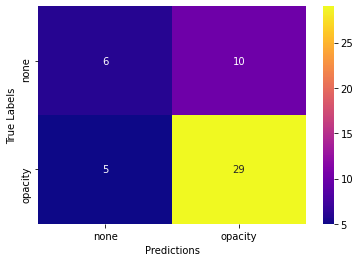

In [94]:
def plot_svm_confusion_matrix(svc, x_test, y_test):
    
    actual =  y_test
    preds = svc.predict(x_test)
    cfmx = confusion_matrix(actual, preds)
    acc = accuracy_score(actual, preds)    
    
    plt.figure()
    sns.heatmap(cfmx, annot=True, cmap='plasma',
        xticklabels=list(np.unique(y_test)),
            fmt='.0f', 
            yticklabels=list(np.unique(y_test))
            )
    plt.xlabel("Predictions")
    plt.ylabel("True Labels")
    plt.show()
    
plot_svm_confusion_matrix(svc, x_test, y_test)